In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',500)

from pylab import rcParams
import statsmodels.api as sm
from numpy.random import normal, seed
from sklearn.metrics import classification_report
from scipy.stats import norm
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC,LinearSVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

import math
from sklearn.metrics import mean_squared_error
#%config IPCompleter.greedy=True

In [2]:
user_reg=pd.read_csv('Data/Registration.csv')
app_uninstal=pd.read_csv('Data/AppUninstalled.csv')
utm_visit=pd.read_csv('Data/UTMVisited.csv')
vid_det=pd.read_csv('Data/VideoDetails.csv')
vid_started=pd.read_csv('Data/VideoStarted.csv')
app_launch=pd.read_csv('Data/AppLaunched.csv')

In [3]:
import os
import pandas as pd
import numpy as np
import datetime
import warnings
warnings.filterwarnings('ignore')

basedir = r'C:\Users\DELL\Downloads\CLEVERTAP_SAJIB\Data'
applaunched,appuninstalled ,registration , utmvisited,videodetails,videostarted = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
event_type = {'AppLaunched':1,'AppUninstalled':2,'Registration':3,'UTMVisited':4,'VideoDetails':5,'VideoStarted':6}

columns_list = []

for rec in os.listdir(basedir):
    tmp = pd.read_csv(basedir+'/'+rec)
    tmp.drop_duplicates(inplace=True)
    for col in tmp.columns:
        if col not in columns_list:
            columns_list.append(col)   
    if rec == 'AppLaunched.csv':
        tmp['event_type'] = event_type.get('AppLaunched')
        applaunched = tmp
    elif rec == 'AppUninstalled.csv':
        tmp['event_type'] = event_type.get('AppUninstalled')
        appuninstalled = tmp
    elif rec == 'Registration.csv':
        tmp['event_type'] = event_type.get('Registration')
        registration = tmp
    elif rec == 'UTMVisited.csv':
        tmp['event_type'] = event_type.get('UTMVisited')
        utmvisited = tmp
    elif rec == 'VideoDetails.csv':
        tmp['event_type'] = event_type.get('VideoDetails')
        videodetails = tmp
    elif rec == 'VideoStarted.csv': 
        tmp['event_type'] = event_type.get('VideoStarted')
        videostarted = tmp
        
    
data = pd.concat( [applaunched,appuninstalled,registration,utmvisited,videodetails,videostarted] , axis=0)
data['Date'] = pd.to_datetime(data['Date'],format='%Y%m%d')

In [4]:
tmp_current_df = data.loc[ (data['event_type'].isin([2,3]) ) ].groupby('UserId')['UserId','event_type'].tail(1)
current_users = set(tmp_current_df.loc[tmp_current_df['event_type'] == 3,'UserId'])

print('List of users active ',len(current_users))

List of users active  259318


In [5]:
print('List of users in registration ',registration['UserId'].nunique())
print('-'*70)

print('User with both completed and Not completed registration')
print('-'*70)
user_registration_count=registration.groupby(['UserId','Status']).size().unstack().fillna(0).sort_values(['Completed','Not Completed'],ascending=False)

user_registration_count.head()

List of users in registration  259318
----------------------------------------------------------------------
User with both completed and Not completed registration
----------------------------------------------------------------------


Status,Complete,Completed,Not Completed
UserId,,,
8bbb1c03eae7ff6d8523dda861e27045,0.0,545.0,1.0
757e76a31d57178a42cc0157e6c32048,0.0,37.0,3.0
5b3d76d28925459f99dc05526168a374,0.0,30.0,4.0
c519adb3903b3d83c46dcf05a9db441a,0.0,19.0,24.0
b29b5693eab25d00bd5f493a2e014a20,0.0,18.0,0.0


In [6]:
app_vs_utm=applaunched.groupby(['UserId','Date','Minute_Of_Day','Second']).size().to_frame().merge(
    utmvisited.groupby(['UserId','Date','Minute_Of_Day','Second']).size().to_frame(),
    left_index=True,
    right_index=True,
    how = 'left')

In [7]:
app_vs_utm.columns = ['AppLaunched','UTMVisited']

app_vs_utm.reset_index(inplace=True)

In [8]:
app_vs_utm['Active'] = app_vs_utm['UserId'].apply(lambda x:'Yes' if x in current_users else 'No')

#app_vs_utm.drop('Active',axis=1,inplace=True)

app_vs_utm['UTMVisited'].fillna(0,inplace=True)
app_vs_utm['Percentage'] = app_vs_utm['UTMVisited'] / app_vs_utm['AppLaunched'] * 100


In [9]:
app_vs_utm = (app_vs_utm.groupby(['UserId','Active']).sum())[['AppLaunched','UTMVisited','Percentage']]

app_vs_utm['Percentage'] = app_vs_utm['UTMVisited'] / app_vs_utm['AppLaunched'] * 100

app_vs_utm.sort_values('UTMVisited',ascending=False).head(20)


,,AppLaunched,UTMVisited,Percentage
UserId,Active,,,
1392344c990b574acfbbc634baafe29a,Yes,132,109.0,82.575758
74160e0d992b2ee89b64c0ab46a052c6,Yes,157,91.0,57.961783
5469007a6ae53f0a01e16ab3a07b5634,Yes,96,71.0,73.958333
88e22fd666b0d0872dc6dffc3a6366f0,Yes,182,64.0,35.164835
3c6a96065ab3fd03d60dad64de622e7a,Yes,294,63.0,21.428571
ebfd00f1fe90dff41f00137a80cb104c,Yes,79,63.0,79.746835
8d2ce7ba87a37b183ad1244e9bba87de,Yes,102,60.0,58.823529
ba9fe865010653c188ce6c842c3563e6,Yes,109,58.0,53.211009
596b1919e5d46f1e3643982d6a839a58,Yes,111,55.0,49.549550


In [10]:
def gen_master_data(data):
    tmp_data=pd.DataFrame()
    tmp_data['UserId'] = data['UserId'].unique()
    tmp_data['Registered_Status'] = tmp_data['UserId'].apply(lambda x: 'Y' if x in current_users else 'N')
    
    
    #To get number of Device
    tmp_data=tmp_data.merge(pd.DataFrame(data=applaunched.groupby('UserId')['Device'].nunique()),
                            how='left',
                            left_on='UserId',
                            right_index=True)
    
    tmp_data.rename(columns={'Device':'No_of_Devices'},inplace=True)
    
    #To get number of Device uninstalled
    tmp_data=tmp_data.merge(pd.DataFrame(data=appuninstalled.groupby('UserId')['Device'].nunique()),
                            how='left',
                            left_on='UserId',
                            right_index=True)
    
    tmp_data.rename(columns={'Device':'No_of_Uninstalled_Device'},inplace=True)
    
    #Deriving last login time
    tmp_data=tmp_data.merge(data.loc[data['event_type'].isin([1,3,4,5,6]),['UserId','Date']].groupby('UserId').max(),
                            how='left',
                            left_on='UserId',
                            right_index=True)
    
    tmp_data.rename(columns={'Date':'Last_Login_Time'},inplace=True)
    tmp_data['Last_Login_Time'].fillna(data['Date'].min(),inplace=True)
    
    #Deriving the last login device and os
    tmp_data=tmp_data.merge(data.loc[ data['event_type'].isin([1,3,4,5,6]) ,['UserId','Date','Device','OS']].sort_values(['UserId','Date']).groupby('UserId').tail(1),
                            how='left',
                            left_on='UserId',
                            right_on = 'UserId'
                           )
    tmp_data.rename(columns={'Device':'Last_Login_Device',
                             'OS':'Last_Login_OS'
                            },inplace=True)
    tmp_data.drop('Date',axis=1,inplace=True)
    
    #Deriving the user country and state
    tmp_data=tmp_data.merge(data.loc[data['event_type'].isin([1,3,4,5,6]),['UserId','Country','State']].groupby('UserId').tail(1),
                            how='left',
                            left_on='UserId',
                            right_on='UserId')
    
    
    #Deriving the count of videos watched in genre
    tmp_data = tmp_data.merge(pd.pivot_table(videostarted[['UserId','Genre']],index='UserId',columns='Genre',aggfunc='size').fillna(0),
                              how='left',
                              left_on = 'UserId',
                              right_index=True)
    
    #Deriving the count of videos watched in ProgramType
    tmp_data = tmp_data.merge(pd.pivot_table(videostarted[['UserId','ProgramType']],index='UserId',columns='ProgramType',aggfunc='size').fillna(0),
                              how='left',
                              left_on = 'UserId',
                              right_index=True)
    
    
    #Deriving no of app launches
    tmp_data = tmp_data.merge(pd.DataFrame(data=applaunched.groupby('UserId').size(),columns=['No_of_AppLaunches']),
                              how='left',
                              left_on='UserId',
                              right_index=True)
    
    #Deriving no of app launches through UTM
    tmp_data = tmp_data.merge(app_vs_utm.groupby('UserId').sum()[['UTMVisited']],
                              how='left',
                              left_on='UserId',
                              right_index=True)
    
    tmp_data.rename(columns={'UTMVisited':'No_of_UTMLaunches'},inplace=True)
    
    #Deriving videos watched in quarter of the day 
    q_dict={0: 'q1', 1: 'q1', 2: 'q1', 3: 'q1', 4: 'q1', 5: 'q1', 
        6: 'q2', 7: 'q2', 8: 'q2', 9: 'q2', 10: 'q2', 11: 'q2', 
        12: 'q3', 13: 'q3', 14: 'q3', 15: 'q3', 16: 'q3', 17: 'q3', 
        18: 'q4', 19: 'q4', 20: 'q4', 21: 'q4', 22: 'q4', 23: 'q4'}
        
    videostarted['quarter_of_day'] = (videostarted['Minute_Of_Day'].apply(lambda x: q_dict.get(x//60) ))

    tmp_data = tmp_data.merge(pd.pivot_table(videostarted[['UserId','quarter_of_day']],
                                             index='UserId',
                                             columns='quarter_of_day',
                                             aggfunc='size').fillna(0),
                              how='left',
                              left_on='UserId',
                              right_index=True)
    
    #derving no of videos watched
    tmp_data = tmp_data.merge(pd.DataFrame(data=videostarted.groupby('UserId').size(),columns=['No_of_Videos_Watched']),
                              how='left',
                              left_on = 'UserId',
                              right_index=True
                             )
    
    #Deriving average visit time per user 
    #applaunched['LaunchDate'] = [ rec_d.strftime("%Y%m%d")  + ' ' + str(rec_m // 60).zfill(2) + ':' +str(rec_m % 60).zfill(2) + ':' + str(rec_s).zfill(2) 
                                 #for rec_d,rec_m,rec_s in zip(applaunched['Date'],applaunched['Minute_Of_Day'],applaunched['Second'])  
                                #]
    
    applaunched['LaunchDate'] = pd.to_datetime(applaunched['Date'],format='%Y%m%d %H:%M:%S')
    applaunched['PrevLaunch'] = applaunched.groupby('UserId')['LaunchDate'].shift(1)
    applaunched['timediff'] = (applaunched['LaunchDate']- applaunched['PrevLaunch']).dt.seconds
    tmp_data = tmp_data.merge(applaunched[['timediff','UserId']].groupby('UserId').mean().fillna(0),
                              how='left',
                              left_on = 'UserId',
                              right_index=True
                             )
    
    tmp_data.rename(columns={'timediff':'Average_visit_duration'},inplace=True)
    
    #Deriving the app reinstalled for user
    df_reinstalled= appuninstalled.groupby('UserId')['Date'].max().to_frame().merge(applaunched.groupby('UserId')['Date'].max().to_frame(),
                                                                left_index=True,
                                                                right_index=True,how='outer',
                                                                suffixes=['_uninstalled','_launched'] )
    
    df_reinstalled['Reinstalled'] = df_reinstalled['Date_uninstalled'] < df_reinstalled['Date_launched']
    df_reinstalled['Reinstalled'] = df_reinstalled['Reinstalled'].astype(int)
    
    tmp_data = tmp_data.merge( df_reinstalled[['Reinstalled']] ,
                              how='left',
                              left_on = 'UserId',
                              right_index =True
                             )
        
    # Deriving the unique video watching ration per genre
    tmp_data = tmp_data.merge(videostarted.groupby(['UserId','Genre'])['VideoId'].nunique().unstack().fillna(0),
                            how='left',
                            left_on = 'UserId',
                            right_index =True,
                            suffixes = ['','_video_ratio']
                             )
    
    video_per_genre = videodetails.groupby(['Genre'])['VideoId'].nunique()
    
    for col in tmp_data.columns:
        try:
            if col.endswith('_video_ratio'):
                genre_total_vid = video_per_genre.loc[col.replace('_video_ratio','')]
                tmp_data[col] = tmp_data[col] / genre_total_vid
        except:
            print("An exception occurred")
                
    return tmp_data.fillna(0)   

master_data = gen_master_data(data)
print('Total rows ',master_data.shape[0])
master_data.head(5)

An exception occurred
Total rows  466124


,UserId,Registered_Status,No_of_Devices,No_of_Uninstalled_Device,Last_Login_Time,Last_Login_Device,Last_Login_OS,Country,State,,Action,Adventure,Animation,Anime,Athletics,Automotive,Award Show,Badminton,Comedy,Concerts,Cooking,Crime,Current Affairs / General,Documentary,Drama,Entertainment,Entertainment News,Equestrian,Family,Fashion,Food,Football,Game Show,General,Golf,Hockey,Horror,Horror / Supernatural,Martial Sports,Motor Sports,Music,Musical / Opera,Mystery,Other Sports (General),Others,Reality,Reality Show,Religious,Romance,Series,Special Event,Sports Magazine,TV Shows (General),Talk Show,Team Sports (Excl. Football),Tennis / Squash,Thriller,Travel,Unknown,Variety,Wrestling,Channels,Movies,TV Shows,No_of_AppLaunches,No_of_UTMLaunches,q1,q2,q3,q4,No_of_Videos_Watched,Average_visit_duration,Reinstalled,_video_ratio,Action _video_ratio,Adventure _video_ratio,Animation _video_ratio,Anime _video_ratio,Athletics _video_ratio,Automotive _video_ratio,Award Show _video_ratio,Badminton _video_ratio,Comedy _video_ratio,Concerts _video_ratio,Cooking _video_ratio,Crime _video_ratio,Current Affairs / General _video_ratio,Documentary _video_ratio,Drama _video_ratio,Entertainment _video_ratio,Entertainment News _video_ratio,Equestrian _video_ratio,Family _video_ratio,Fashion _video_ratio,Food _video_ratio,Football _video_ratio,Game Show _video_ratio,General _video_ratio,Golf _video_ratio,Hockey _video_ratio,Horror _video_ratio,Horror / Supernatural _video_ratio,Martial Sports _video_ratio,Motor Sports _video_ratio,Music _video_ratio,Musical / Opera _video_ratio,Mystery _video_ratio,Other Sports (General) _video_ratio,Others _video_ratio,Reality _video_ratio,Reality Show _video_ratio,Religious _video_ratio,Romance _video_ratio,Series _video_ratio,Special Event _video_ratio,Sports Magazine _video_ratio,TV Shows (General) _video_ratio,Talk Show _video_ratio,Team Sports (Excl. Football) _video_ratio,Tennis / Squash _video_ratio,Thriller _video_ratio,Travel _video_ratio,Unknown _video_ratio,Variety _video_ratio,Wrestling _video_ratio
0,a27134c322d4f56dabc106a6847cb96b,N,1.0,0.0,2017-01-06,1.0,2.0,1.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,342.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1,aab39ad0874c59cc388525d511667f9d,N,1.0,0.0,2017-03-01,1.0,2.0,1.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000727,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2,f717dc3f757dc18cc0c3f27ed3e94ef8,N,2.0,2.0,2017-06-11,2.0,2.0,1.0,35.0,28.0,6.0,0.0,0.0,11.0,0.0,0.0,0.0,25.0,2.0,0.0,0.0,0.0,3.0,0.0,34.0,3.0,0.0,0.0,0.0,4.0,6.0,53.0,0.0,1.0,0.0,0.0,4.0,3.0,6.0,50.0,0.0,0.0,0.0,18.0,0.0,0.0,4.0,0.0,3.0,2.0,1.0,113.0,9.0,0.0,0.0,24.0,1.0,0.0,0.0,0.0,0.0,395.0,8.0,11.0,106.0,0.0,13.0,53.0,28.0,320.0,414.0,0.0,1.0,1.0,0.026316,0.0,0.0,0.011254,0.0,0.0,0.0,0.333333,0.004464,0.0,0.0,0.0,0.5,0.0,0.006541,0.066667,0.0,0.0,0.0,0.25,0.5,1.0,0.0,0.5,0.0,0.0,0.028169,1.0,1.5,0.5,0.0,0.0,0.0,1.333333,0.0,0.0,0.028037,0.0,0.010526,0.5,0.5,0.6,0.6,0.0,0.0,0.333333,0.033333,0.0,0.0,0.0,0.0
3,04c1e14fd54a06c0d4fe98cf0cb8b04c,N,1.0,0.0,2017-01-10,2.0,2.0,1.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [11]:
master_data.loc[master_data['Last_Login_Time'] == 0,'Last_Login_Time'] = data['Date'].min()
master_data['Dormant'] = (data['Date'].max() - master_data['Last_Login_Time']).dt.days > 30

master_data['Dormant'] = master_data['Dormant'].astype(int)

master_data.head()

,UserId,Registered_Status,No_of_Devices,No_of_Uninstalled_Device,Last_Login_Time,Last_Login_Device,Last_Login_OS,Country,State,,Action,Adventure,Animation,Anime,Athletics,Automotive,Award Show,Badminton,Comedy,Concerts,Cooking,Crime,Current Affairs / General,Documentary,Drama,Entertainment,Entertainment News,Equestrian,Family,Fashion,Food,Football,Game Show,General,Golf,Hockey,Horror,Horror / Supernatural,Martial Sports,Motor Sports,Music,Musical / Opera,Mystery,Other Sports (General),Others,Reality,Reality Show,Religious,Romance,Series,Special Event,Sports Magazine,TV Shows (General),Talk Show,Team Sports (Excl. Football),Tennis / Squash,Thriller,Travel,Unknown,Variety,Wrestling,Channels,Movies,TV Shows,No_of_AppLaunches,No_of_UTMLaunches,q1,q2,q3,q4,No_of_Videos_Watched,Average_visit_duration,Reinstalled,_video_ratio,Action _video_ratio,Adventure _video_ratio,Animation _video_ratio,Anime _video_ratio,Athletics _video_ratio,Automotive _video_ratio,Award Show _video_ratio,Badminton _video_ratio,Comedy _video_ratio,Concerts _video_ratio,Cooking _video_ratio,Crime _video_ratio,Current Affairs / General _video_ratio,Documentary _video_ratio,Drama _video_ratio,Entertainment _video_ratio,Entertainment News _video_ratio,Equestrian _video_ratio,Family _video_ratio,Fashion _video_ratio,Food _video_ratio,Football _video_ratio,Game Show _video_ratio,General _video_ratio,Golf _video_ratio,Hockey _video_ratio,Horror _video_ratio,Horror / Supernatural _video_ratio,Martial Sports _video_ratio,Motor Sports _video_ratio,Music _video_ratio,Musical / Opera _video_ratio,Mystery _video_ratio,Other Sports (General) _video_ratio,Others _video_ratio,Reality _video_ratio,Reality Show _video_ratio,Religious _video_ratio,Romance _video_ratio,Series _video_ratio,Special Event _video_ratio,Sports Magazine _video_ratio,TV Shows (General) _video_ratio,Talk Show _video_ratio,Team Sports (Excl. Football) _video_ratio,Tennis / Squash _video_ratio,Thriller _video_ratio,Travel _video_ratio,Unknown _video_ratio,Variety _video_ratio,Wrestling _video_ratio,Dormant
0,a27134c322d4f56dabc106a6847cb96b,N,1.0,0.0,2017-01-06,1.0,2.0,1.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,342.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1
1,aab39ad0874c59cc388525d511667f9d,N,1.0,0.0,2017-03-01,1.0,2.0,1.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000727,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1
2,f717dc3f757dc18cc0c3f27ed3e94ef8,N,2.0,2.0,2017-06-11,2.0,2.0,1.0,35.0,28.0,6.0,0.0,0.0,11.0,0.0,0.0,0.0,25.0,2.0,0.0,0.0,0.0,3.0,0.0,34.0,3.0,0.0,0.0,0.0,4.0,6.0,53.0,0.0,1.0,0.0,0.0,4.0,3.0,6.0,50.0,0.0,0.0,0.0,18.0,0.0,0.0,4.0,0.0,3.0,2.0,1.0,113.0,9.0,0.0,0.0,24.0,1.0,0.0,0.0,0.0,0.0,395.0,8.0,11.0,106.0,0.0,13.0,53.0,28.0,320.0,414.0,0.0,1.0,1.0,0.026316,0.0,0.0,0.011254,0.0,0.0,0.0,0.333333,0.004464,0.0,0.0,0.0,0.5,0.0,0.006541,0.066667,0.0,0.0,0.0,0.25,0.5,1.0,0.0,0.5,0.0,0.0,0.028169,1.0,1.5,0.5,0.0,0.0,0.0,1.333333,0.0,0.0,0.028037,0.0,0.010526,0.5,0.5,0.6,0.6,0.0,0.0,0.333333,0.033333,0.0,0.0,0.0,0.0,0
3,04c1e14fd54a06c0d4fe98cf0cb8b04c,N,1.0,0.0,2017-01-10,2.0,2.0,1.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [12]:
master_data.to_csv('C:/Users/DELL/Downloads/CLEVERTAP_SAJIB/Clever_Tap_Master_Data.csv')

In [13]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
master_data['UserId']=lb_make.fit_transform(master_data['UserId'])
master_data['Registered_Status']=lb_make.fit_transform(master_data['Registered_Status'])

master_data.head()

,UserId,Registered_Status,No_of_Devices,No_of_Uninstalled_Device,Last_Login_Time,Last_Login_Device,Last_Login_OS,Country,State,,Action,Adventure,Animation,Anime,Athletics,Automotive,Award Show,Badminton,Comedy,Concerts,Cooking,Crime,Current Affairs / General,Documentary,Drama,Entertainment,Entertainment News,Equestrian,Family,Fashion,Food,Football,Game Show,General,Golf,Hockey,Horror,Horror / Supernatural,Martial Sports,Motor Sports,Music,Musical / Opera,Mystery,Other Sports (General),Others,Reality,Reality Show,Religious,Romance,Series,Special Event,Sports Magazine,TV Shows (General),Talk Show,Team Sports (Excl. Football),Tennis / Squash,Thriller,Travel,Unknown,Variety,Wrestling,Channels,Movies,TV Shows,No_of_AppLaunches,No_of_UTMLaunches,q1,q2,q3,q4,No_of_Videos_Watched,Average_visit_duration,Reinstalled,_video_ratio,Action _video_ratio,Adventure _video_ratio,Animation _video_ratio,Anime _video_ratio,Athletics _video_ratio,Automotive _video_ratio,Award Show _video_ratio,Badminton _video_ratio,Comedy _video_ratio,Concerts _video_ratio,Cooking _video_ratio,Crime _video_ratio,Current Affairs / General _video_ratio,Documentary _video_ratio,Drama _video_ratio,Entertainment _video_ratio,Entertainment News _video_ratio,Equestrian _video_ratio,Family _video_ratio,Fashion _video_ratio,Food _video_ratio,Football _video_ratio,Game Show _video_ratio,General _video_ratio,Golf _video_ratio,Hockey _video_ratio,Horror _video_ratio,Horror / Supernatural _video_ratio,Martial Sports _video_ratio,Motor Sports _video_ratio,Music _video_ratio,Musical / Opera _video_ratio,Mystery _video_ratio,Other Sports (General) _video_ratio,Others _video_ratio,Reality _video_ratio,Reality Show _video_ratio,Religious _video_ratio,Romance _video_ratio,Series _video_ratio,Special Event _video_ratio,Sports Magazine _video_ratio,TV Shows (General) _video_ratio,Talk Show _video_ratio,Team Sports (Excl. Football) _video_ratio,Tennis / Squash _video_ratio,Thriller _video_ratio,Travel _video_ratio,Unknown _video_ratio,Variety _video_ratio,Wrestling _video_ratio,Dormant
0,295825,0,1.0,0.0,2017-01-06,1.0,2.0,1.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,342.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1
1,310721,0,1.0,0.0,2017-03-01,1.0,2.0,1.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000727,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1
2,449916,0,2.0,2.0,2017-06-11,2.0,2.0,1.0,35.0,28.0,6.0,0.0,0.0,11.0,0.0,0.0,0.0,25.0,2.0,0.0,0.0,0.0,3.0,0.0,34.0,3.0,0.0,0.0,0.0,4.0,6.0,53.0,0.0,1.0,0.0,0.0,4.0,3.0,6.0,50.0,0.0,0.0,0.0,18.0,0.0,0.0,4.0,0.0,3.0,2.0,1.0,113.0,9.0,0.0,0.0,24.0,1.0,0.0,0.0,0.0,0.0,395.0,8.0,11.0,106.0,0.0,13.0,53.0,28.0,320.0,414.0,0.0,1.0,1.0,0.026316,0.0,0.0,0.011254,0.0,0.0,0.0,0.333333,0.004464,0.0,0.0,0.0,0.5,0.0,0.006541,0.066667,0.0,0.0,0.0,0.25,0.5,1.0,0.0,0.5,0.0,0.0,0.028169,1.0,1.5,0.5,0.0,0.0,0.0,1.333333,0.0,0.0,0.028037,0.0,0.010526,0.5,0.5,0.6,0.6,0.0,0.0,0.333333,0.033333,0.0,0.0,0.0,0.0,0
3,8810,0,1.0,0.0,2017-01-10,2.0,2.0,1.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [14]:
from sklearn.preprocessing import StandardScaler

X=master_data.select_dtypes(exclude=['datetime64'])
X=StandardScaler().fit_transform(X)


# PCA (Principal Component Analysis):

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(random_state=123)
pca.fit(X)
features = range(pca.n_components_)

plt.figure(figsize=(8,4))
plt.bar(features[:15], pca.explained_variance_[:15], color='lightskyblue')
plt.xlabel('PCA feature')
plt.ylabel('Variance')
plt.xticks(features[:15])
plt.show()


In [17]:
from sklearn.decomposition import PCA

columns_list = list(set(master_data.columns) - set(['UserId','Last_Login_Time','Country','State','No_of_Devices',
                                                    'No_of_Uninstalled_Device',
                                                    'Last_Login_OS',
                                                    'Last_Login_Device','cluster_name','cluster']))

pca = PCA(n_components=2)

pca_result = pca.fit_transform(master_data[columns_list])
print(np.sum(pca.explained_variance_ratio_))

0.967748815639202


# check the optimal k value:

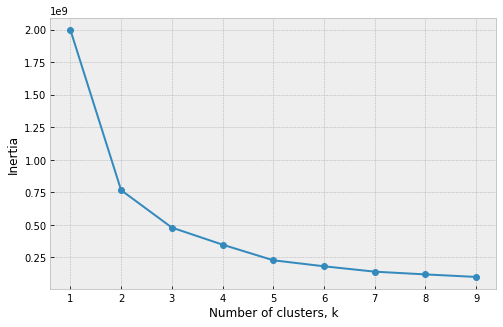

In [18]:
from sklearn.cluster import KMeans

ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(pca_result)
    inertias.append(model.inertia_)

plt.figure(figsize=(8,5))
plt.style.use('bmh')
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

<Figure size 792x576 with 0 Axes>

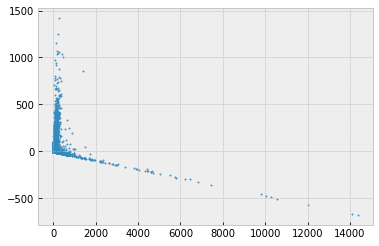

<Figure size 792x576 with 0 Axes>

In [19]:
from mpl_toolkits import mplot3d

plt.scatter(pca_result[:,0],pca_result[:,1],s=2,alpha=0.8)
plt.figure(figsize=(11,8))

# TSNE:

In [20]:
import time

from sklearn.manifold import TSNE

n_sne = 7000

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1)
tsne_results = tsne.fit_transform(master_data.select_dtypes(exclude=['datetime64']).iloc[:10000,:])

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.266s...
[t-SNE] Computed neighbors for 10000 samples in 1.980s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 27.693843
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.136936
[t-SNE] KL divergence after 1000 iterations: 0.429164
t-SNE done! Time elapsed

t-SNE done! Time elapsed: 120.12745499610901 seconds


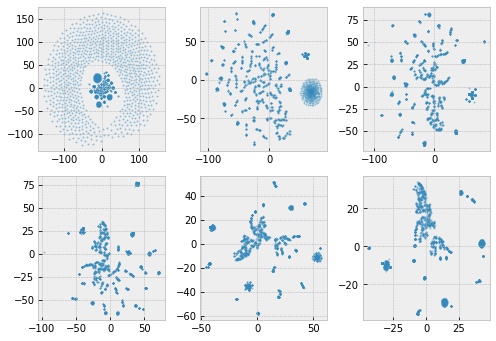

In [21]:
import time
from sklearn.manifold import TSNE

time_start = time.time()
counter=1
plt.figure(figsize=(7,7))
for p_val in [0,5,10,15,30,50]:
    tsne = TSNE(n_components=2, verbose=0,perplexity=p_val )
    tsne_results = tsne.fit_transform(pca_result[:2000,:])
    plt.subplot(3,3,counter)
    plt.scatter(tsne_results[:,0],tsne_results[:,1],s=2,alpha=0.4)
    plt.tight_layout()
    counter+=1
    
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


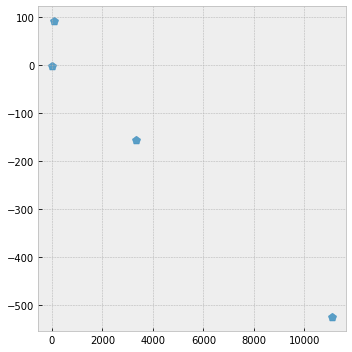

In [22]:
from sklearn.cluster import KMeans

inertia = []
plt.figure(figsize=(5,5))
for tot_cluster in [4]:
    kmeans = KMeans(n_clusters=tot_cluster,init='random',random_state=0,max_iter=300)
    kmeans_df = kmeans.fit_transform(pca_result)
    inertia.append(kmeans.inertia_)
    plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],s=75,alpha=0.8,marker='p',norm=1)
    plt.tight_layout()
    
master_data['cluster'] = kmeans.labels_


In [23]:
master_data.groupby('cluster').sum()['No_of_Videos_Watched'] / master_data['No_of_Videos_Watched'].sum() * 100 

cluster
0     0.001078
1    60.624780
2    39.364629
3     0.009512
Name: No_of_Videos_Watched, dtype: float64

In [24]:
cluster_classification = { 0: 'Guest Dormant',
                           1: 'Registered Dormant' ,
                           2: 'Guest Active',
                           3: 'Registered Active'     
                         }


In [25]:
X = master_data.drop(['cluster','Last_Login_Time'],axis=1)
y = master_data['cluster']


In [26]:
from sklearn.ensemble import RandomForestClassifier 

rf = RandomForestClassifier() 

rf.fit(X, y) 
rf.score(X, y)

feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

feature_importances.to_csv('feature_importance_4.csv')

In [27]:
final_df=master_data[['Average_visit_duration',
'No_of_AppLaunches',
'q3',
'q2',
'UserId',
' TV Shows',
' Drama ',
'No_of_UTMLaunches',
'q4',
' Channels',
'State',
'No_of_Videos_Watched',
'Dormant',
' Romance _video_ratio','cluster']]
        

In [28]:
X = final_df.drop(['cluster'],axis=1)
y = final_df['cluster']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=20)

print('Train shape ',X_train.shape)
print('Test shape ',X_test.shape)
 

Train shape  (372899, 14)
Test shape  (93225, 14)


In [29]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, y_train) * 100, 2)
print(round(acc_log,2,), "%")

print(classification_report(y_test,y_pred,target_names=list(cluster_classification.values())))
print(confusion_matrix(y_test,y_pred,labels=range(4)))

98.74 %
                    precision    recall  f1-score   support

     Guest Dormant       0.00      0.00      0.00         4
Registered Dormant       0.99      0.99      0.99     91439
      Guest Active       0.66      0.72      0.69      1773
 Registered Active       0.20      0.11      0.14         9

          accuracy                           0.99     93225
         macro avg       0.46      0.46      0.46     93225
      weighted avg       0.99      0.99      0.99     93225

[[    0     0     0     4]
 [    0 90780   659     0]
 [    0   498  1275     0]
 [    0     0     8     1]]


In [30]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)

y_pred = linear_svc.predict(X_test)

acc_linear_svc = round(linear_svc.score(X_train, y_train) * 100, 2)
print(round(acc_linear_svc,2,), "%")

print(classification_report(y_test,y_pred,target_names=list(cluster_classification.values())))
print(confusion_matrix(y_test,y_pred,labels=range(4)))

98.87 %
                    precision    recall  f1-score   support

     Guest Dormant       0.00      0.00      0.00         4
Registered Dormant       0.99      1.00      0.99     91439
      Guest Active       0.87      0.50      0.63      1773
 Registered Active       0.00      0.00      0.00         9

          accuracy                           0.99     93225
         macro avg       0.47      0.37      0.41     93225
      weighted avg       0.99      0.99      0.99     93225

[[    0     0     4     0]
 [    0 91323   116     0]
 [    0   894   879     0]
 [    0     0     9     0]]


In [31]:
# Gaussian Naive Bayes
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)

y_pred = gaussian.predict(X_test)

acc_gaussian = round(gaussian.score(X_train, y_train) * 100, 2)
print(round(acc_gaussian,2,), "%")

cm_nv = confusion_matrix(y_test, y_pred)

print(classification_report(y_test,y_pred,target_names=list(cluster_classification.values())))
print(confusion_matrix(y_test,y_pred,labels=range(4)))

97.95 %
                    precision    recall  f1-score   support

     Guest Dormant       1.00      1.00      1.00         4
Registered Dormant       1.00      0.98      0.99     91439
      Guest Active       0.49      0.97      0.65      1773
 Registered Active       0.08      1.00      0.14         9

          accuracy                           0.98     93225
         macro avg       0.64      0.99      0.70     93225
      weighted avg       0.99      0.98      0.98     93225

[[    4     0     0     0]
 [    0 89607  1783    49]
 [    0     0  1713    60]
 [    0     0     0     9]]


In [32]:
decision_tree = DecisionTreeClassifier(max_depth = 2)
decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)

acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)
print(round(acc_decision_tree,2,), "%")

print(classification_report(y_test,y_pred,target_names=list(cluster_classification.values())))
print(confusion_matrix(y_test,y_pred,labels=range(4)))

99.59 %
                    precision    recall  f1-score   support

     Guest Dormant       0.00      0.00      0.00         4
Registered Dormant       1.00      1.00      1.00     91439
      Guest Active       0.90      0.87      0.88      1773
 Registered Active       0.00      0.00      0.00         9

          accuracy                           1.00     93225
         macro avg       0.47      0.47      0.47     93225
      weighted avg       1.00      1.00      1.00     93225

[[    0     0     4     0]
 [    0 91275   164     0]
 [    0   231  1542     0]
 [    0     0     9     0]]


In [33]:
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors = 10).fit(X_train, y_train) 
  
knn_sc = round(knn.score(X_train, y_train) * 100, 2)
print(round(knn_sc,2,), "%")


# creating a confusion matrix 
knn_predictions = knn.predict(X_test)  

print(classification_report(y_test,y_pred,target_names=list(cluster_classification.values())))
print(confusion_matrix(y_test,y_pred,labels=range(4)))


98.23 %
                    precision    recall  f1-score   support

     Guest Dormant       0.00      0.00      0.00         4
Registered Dormant       1.00      1.00      1.00     91439
      Guest Active       0.90      0.87      0.88      1773
 Registered Active       0.00      0.00      0.00         9

          accuracy                           1.00     93225
         macro avg       0.47      0.47      0.47     93225
      weighted avg       1.00      1.00      1.00     93225

[[    0     0     4     0]
 [    0 91275   164     0]
 [    0   231  1542     0]
 [    0     0     9     0]]


In [34]:
from sklearn.model_selection import cross_validate, ShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV, SGDClassifier
from sklearn import ensemble, naive_bayes, svm, tree, discriminant_analysis, neighbors, feature_selection
from sklearn.model_selection import cross_validate, ShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV, SGDClassifier
from sklearn import ensemble, naive_bayes, svm, tree, discriminant_analysis, neighbors, feature_selection



In [35]:
cv_split = ShuffleSplit(n_splits = 10, test_size = .3, train_size = .7, random_state = 0)


In [ ]:
from sklearn.model_selection import cross_validate, ShuffleSplit, GridSearchCV
dtree = DecisionTreeClassifier(random_state = 0)
base_results_dtree = cross_validate(dtree, X, y, cv  = cv_split, return_train_score=True)
dtree.fit(X, y)

epoch=0
for train_score,test_score in zip(base_results_dtree['train_score'], base_results_dtree['test_score']):
        epoch +=1       
        print("epoch:",epoch,"train_score:",train_score, "test_score:",test_score)
print('-'*10)

print('BEFORE Tuning Parameters: ', dtree.get_params())
print("BEFORE Tuning Training w/bin score mean: {:.2f}". format(base_results_dtree['train_score'].mean()*100)) 
print("BEFORE Tuning Test w/bin score mean: {:.2f}". format(base_results_dtree['test_score'].mean()*100))
print('-'*10)

param_grid = {'criterion': ['gini','entropy'], 
              'splitter': ['best', 'random'], 
              'max_depth': [2,4,6,8,10,None], 
              'min_samples_split': [2,5,7,10,12], 
              'min_samples_leaf': [1,3,5,7, 10], 
              'random_state': [0] 
             }


tune_model = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, scoring = 'accuracy', cv = cv_split, return_train_score=True)
tune_model.fit(X, y)

for i in range(10):
    print("epoch:",i,"train_score:",tune_model.cv_results_['split'+str(i)+'_train_score'][tune_model.best_index_],
    "test_score:",tune_model.cv_results_['split'+str(i)+'_test_score'][tune_model.best_index_])

print('-'*10)    

print('AFTER Tuning Parameters: ', tune_model.best_params_)
print("AFTER Tuning Training w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100))
print("AFTER Tuning Test w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print('-'*10)

epoch: 1 train_score: 1.0 test_score: 0.9990059926486363
epoch: 2 train_score: 1.0 test_score: 0.9989416324604184
epoch: 3 train_score: 1.0 test_score: 0.9989630858564911
epoch: 4 train_score: 1.0 test_score: 0.9989702369885153
epoch: 5 train_score: 1.0 test_score: 0.9988272143480313
epoch: 6 train_score: 1.0 test_score: 0.9990059926486363
epoch: 7 train_score: 1.0 test_score: 0.9988844234042249
epoch: 8 train_score: 1.0 test_score: 0.9988200632160071
epoch: 9 train_score: 1.0 test_score: 0.9990417483087572
epoch: 10 train_score: 1.0 test_score: 0.9990703528368541
----------
BEFORE Tuning Parameters:  {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}
BEFORE Tuning Training w/bin score mean: 100.00
BEFORE Tuning Test w/bin score mean: 99

In [ ]:
dtree = DecisionTreeClassifier(criterion= 'entropy', max_depth= 4, random_state= 0, splitter= 'random')
base_results = cross_validate(dtree, X, y, cv  = cv_split, return_train_score=True)
dtree.fit(X, y)